# README
As part of your onsite coding interview, we ask you to complete three coding tasks prior to the interview.
This is a companion activity to the paper interview https://arxiv.org/abs/1706.06083 that you are also asked to prepare for.
Our goal in this process is to evaluate your ability to understand and implement algorithms in clear and correct python / pytorch code.
This code will be reviewed during the coding portion of your interview, and we will ask you to extend it during the interview.

- To aid and structure your work, we provide you with a skeleton for the code that you should write.
- Feel free to change whatever pre-existing code you want.
    - However, use only use the modules already imported
- Be prepared to explain and discuss the code that you implemented, and to perform changes on it during the coding interview.
- In addition to the *.ipynb*, we also provide two folders: */models* and */data*:
    - The first contains a pretrained MNIST model (*lenet_mnist_model.pth*);
    - The second is empty (this is the directory where the MNIST model will be downloaded to).

We ask that you do not distribute this notebook, and that you work on this notebook by yourself.
Please e-mail the notebook (when completed) to filipe.condessa@us.bosch.com before your onsite.
If you have any pressing questions send an e-mail to filipe.condessa@us.bosch.com.
### And have fun!

### Three Coding Tasks
- Write a class that implements FGSM and PGD attacks on pretrained classifier
- Write an evaluator that can evaluate the efficacy of an attack class on a model
- Implement an adversarial training procedure using PGD adversaries as described in "Towards Deep Learning Models Resistant to Adversarial Attacks"

In [0]:
!pip3 install torch==1.2.0+cu92 torchvision==0.4.0+cu92 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html


In [0]:
# please do not import more models
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

In [0]:
# feel free to use cuda or not
# set devices
use_cuda = True
# define device
print("CUDA Available:", torch.cuda.is_available())
device = torch.device(
"cuda:0" if (use_cuda and torch.cuda.is_available()) else "cpu"
)

CUDA Available: True


In [0]:
# LeNet Model definition
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size = 5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size = 5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)),2))
        x = x.view(-1,320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training = self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [0]:
# feel free to adjust batch sizes
trainLoader = torch.utils.data.DataLoader(
    datasets.MNIST('data',
    train= True,
    download=True,
    transform=transforms.Compose([transforms.ToTensor()])),
    batch_size = 64,
    shuffle = True
)

testLoader = torch.utils.data.DataLoader(
    datasets.MNIST('data',
    train= False,
    download=True,
    transform=transforms.Compose([transforms.ToTensor()])),
    batch_size = 1,
    shuffle = True
)

  0%|          | 0/9912422 [00:00<?, ?it/s]

9920512it [00:00, 20394094.71it/s]                            


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


32768it [00:00, 300662.09it/s]                           
0it [00:00, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw


1654784it [00:00, 4901407.25it/s]                           
8192it [00:00, 118293.00it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw
Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


lbl: 8


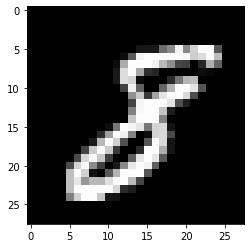

In [0]:
imgs, lbls = next(iter(trainLoader))
plt.imshow(imgs[0][0].numpy(), cmap='gray')
print("lbl:", lbls[0].item())

In [0]:
pretrained_model = 'models/lenet_mnist_model.pth'
# load model
model = Net().to(device)
model.load_state_dict(torch.load(pretrained_model, map_location='cpu'))

def evalNet(model, testLoader):
    model.eval()
    accu = 0
    batch_size = testLoader.batch_size
    for bidx, (imgs, lbls) in enumerate(testLoader):
        _, pred = torch.max(model.forward(imgs.to(device)), 1)
        accu += (pred==lbls.to(device)).sum().item()/batch_size
    accu /= bidx+1
    return accu
print("Baseline accuracy on test set:")
print(evalNet(model, testLoader))

Baseline accuracy on test set:
0.981


## Task 1
- Complete the *Attack* classes (FGSM, PGD) that implement the FGSM and PGD attacks (feel free to edit the *Attack* parent class)
 - The attack should receive as input the original data (one sample at a time), the neural network model, and the value of epsilon for the pertubation;
 - The attack should return an adversarial input to a model
 - The PGD attack should allow $\ell_p$ norms of $p=1,2,\infty$

In [0]:
class Attack:
    '''
    parent class for the attacks
    generate one adversarial example at a time
    '''
    def __init__(self, epsilon):
        self.epsilon = epsilon
    def attack(self, inputData, model):
        pass
    
class FGSM(Attack):
    '''Fast Gradient Sign Method'''
    def __init__(self, epsilon):
        super(FGSM,self).__init__(epsilon)
    def attack(self, inputData, model):
        imgOrig, lbl = inputData[0], inputData[1]
        imgAdv = imgOrig.clone().detach().requires_grad_(True)
        loss_fn = nn.NLLLoss()
        modelOut = model.forward(imgAdv)
        loss = loss_fn(modelOut, lbl)
        loss.backward()
        # add perturbations into image
        updates = torch.sign(imgAdv.grad)*self.epsilon
        imgAdv = imgAdv+updates
        imgAdv = torch.clamp(imgAdv, 0, 1)
        return imgAdv

class PGD(Attack):
    '''Projected Gradient Descent'''
    def __init__(self, epsilon, p, stepsize, numIters):
        super(PGD,self).__init__(epsilon)
        self.p = p
        self.stepsize = stepsize
        self.numIters = numIters

    def attack(self, inputData, model):
        imgOrig, lbl = inputData[0], inputData[1]
        batchsize, channels = imgOrig.shape[0], imgOrig.shape[1]
        H, W = imgOrig.shape[2], imgOrig.shape[3]
        # random start
        delta = torch.rand_like(imgOrig)*2*self.epsilon-self.epsilon
        if self.p!=np.inf: # projected into feasible set if needed
            normVal = torch.norm(delta.view(batchsize, -1), self.p, 1)
            mask = normVal<=self.epsilon
            scaling = self.epsilon/normVal
            scaling[mask] = 1
            delta = delta*scaling.view(batchsize, 1, 1, 1)
        imgAdv = imgOrig+delta
        
        # PGD to get adversarial example
        loss_fn = nn.NLLLoss()
        for i in range(self.numIters):
            imgAdv = imgAdv.clone().detach().requires_grad_(True) # clone the imgAdv as the next iteration input
            modelOut = model.forward(imgAdv)
            loss = loss_fn(modelOut, lbl)
            loss.backward()
            updates = imgAdv.grad
            if self.p==np.inf:
                updates = updates.sign()
            else:
                normVal = torch.norm(updates.view(batchsize, -1), self.p, 1)
                updates = updates/normVal.view(batchsize, 1, 1, 1)
            updates = updates*self.stepsize
            imgAdv = imgAdv+updates
            # project the disturbed image to feasible set if needed
            delta = imgAdv-imgOrig
            if self.p==np.inf:
                delta = torch.clamp(delta, -self.epsilon, self.epsilon)
            else:
                normVal = torch.norm(delta.view(batchsize, -1), self.p, 1)
                mask = normVal<=self.epsilon
                scaling = self.epsilon/normVal
                scaling[mask] = 1
                delta = delta*scaling.view(batchsize, 1, 1, 1)
            imgAdv = imgOrig+delta
            imgAdv = torch.clamp(imgAdv, 0, 1)
        return imgAdv

## Task 2
- Implement a class that allows you to evaluate the effectiveness of a class of attacks for a given epsilon and p (e.g. PGD with p=2 and epsilon =0.1)
 - The evaluator should receive as input an instance of an attack, a model, the testLoader, and the number of samples to test
 - The evaluator should return the proportion of attacks that are successful
 - This class should leverage the testLoader (torch.utils.data.dataLoader)
 - Ignore samples that are initially misclassified by the model
 - Consider a successful attack to be going from a correctly classified sample to a misclassified sample
 - Plot and save some of the perturbated samples as you evaluate an attack

In [0]:
class EvalAttacks:
    def __init__(self):
        pass
    def eval(self, attackMethod, model, testLoader=testLoader, numExamples=50):
        model.eval()
        accu = 0
        i = 0
        while i<numExamples:
            img, lbl = next(iter(testLoader))
            img = img.to(device)
            lbl = lbl.to(device)
            if torch.max(model.forward(img), 1)[1]==lbl:
                i += 1
                img = attackMethod.attack([img, lbl], model)
                _, pred = torch.max(model.forward(img), 1)
                accu += (pred==lbl).sum().item()
        return 1-accu/numExamples

"""attack class instantiation"""
eval_attack = EvalAttacks()

PGD::L-inf
Epsilon--> 0.05 Successful attack rate--> 0.040000000000000036
Epsilon--> 0.1 Successful attack rate--> 0.21999999999999997
Epsilon--> 0.15000000000000002 Successful attack rate--> 0.56
Epsilon--> 0.2 Successful attack rate--> 0.9
Epsilon--> 0.25 Successful attack rate--> 1.0
Epsilon--> 0.30000000000000004 Successful attack rate--> 1.0


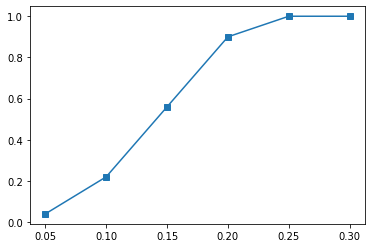

In [0]:
print("PGD::L-inf")
success_rate = []
epsilon = [0.05*i for i in range(1, 7)]
""""""
for ep in epsilon:
    pgd = PGD(ep, np.inf, stepsize=0.01, numIters=100)
    success_rate.append(eval_attack.eval(pgd, model, testLoader, numExamples=50))
    print("Epsilon-->", ep, "Successful attack rate-->", success_rate[-1])
# plot
plt.plot(epsilon, success_rate, marker='s')

PGD::L-2
Epsilon--> 0.5 Successful attack rate--> 0.06000000000000005
Epsilon--> 1.0 Successful attack rate--> 0.21999999999999997
Epsilon--> 1.5 Successful attack rate--> 0.48
Epsilon--> 2.0 Successful attack rate--> 0.6799999999999999
Epsilon--> 2.5 Successful attack rate--> 0.9
Epsilon--> 3.0 Successful attack rate--> 1.0


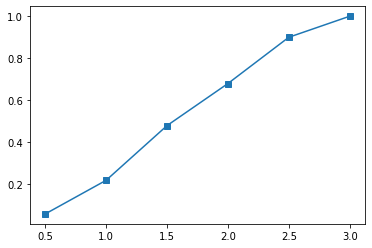

In [0]:
print("PGD::L-2")
success_rate = []
epsilon = [0.5*i for i in range(1, 7)]
""""""
for ep in epsilon:
    pgd = PGD(ep, 2, stepsize=2.5*ep/100, numIters=100)
    success_rate.append(eval_attack.eval(pgd, model, testLoader, numExamples=50))
    print("Epsilon-->", ep, "Successful attack rate-->", success_rate[-1])
# plot
plt.plot(epsilon, success_rate, marker='s')

PGD::L-1
Epsilon--> 5 Successful attack rate--> 0.06000000000000005
Epsilon--> 10 Successful attack rate--> 0.06000000000000005
Epsilon--> 15 Successful attack rate--> 0.30000000000000004
Epsilon--> 20 Successful attack rate--> 0.30000000000000004
Epsilon--> 25 Successful attack rate--> 0.5800000000000001
Epsilon--> 30 Successful attack rate--> 0.64


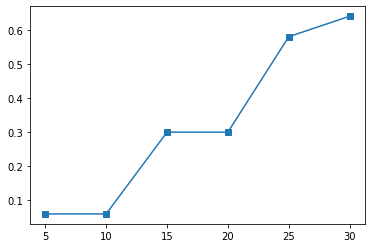

In [0]:
print("PGD::L-1")
success_rate = []
epsilon = [5*i for i in range(1, 7)]
""""""
for ep in epsilon:
    pgd = PGD(ep, 1, stepsize=2.5*ep/100, numIters=100)
    success_rate.append(eval_attack.eval(pgd, model, testLoader, numExamples=50))
    print("Epsilon-->", ep, "Successful attack rate-->", success_rate[-1])
# plot
plt.plot(epsilon, success_rate, marker='s')

FGSM
Epsilon--> 0.05 Successful attack rate--> 0.020000000000000018
Epsilon--> 0.1 Successful attack rate--> 0.09999999999999998
Epsilon--> 0.15000000000000002 Successful attack rate--> 0.28
Epsilon--> 0.2 Successful attack rate--> 0.54
Epsilon--> 0.25 Successful attack rate--> 0.74
Epsilon--> 0.30000000000000004 Successful attack rate--> 0.96


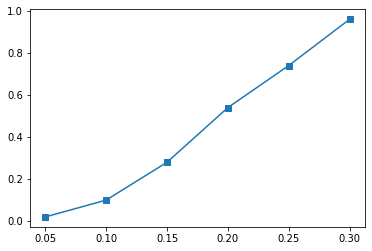

In [0]:
print("FGSM")
success_rate = []
epsilon = [0.05*i for i in range(1, 7)]
""""""
for ep in epsilon:
    fgsm = FGSM(ep)
    success_rate.append(eval_attack.eval(fgsm, model, testLoader, numExamples=50))
    print("Epsilon-->", ep, "Successful attack rate-->", success_rate[-1])
# plot
plt.plot(epsilon, success_rate, marker='s')

5


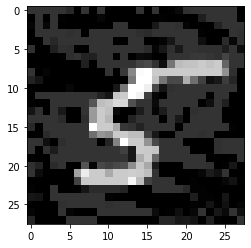

In [0]:
# print some adversarial examples
pgd = PGD(0.2, np.inf, stepsize=0.01, numIters=100)
img, lbl = next(iter(testLoader))
img = pgd.attack([img.to(device), lbl.to(device)], model)
print(lbl.item())
plt.imshow(img.detach().cpu().numpy()[0][0], cmap='gray')

9


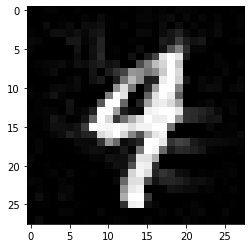

In [0]:
# print some adversarial examples
pgd = PGD(2, 2, stepsize=2.5*2/100, numIters=100)
img, lbl = next(iter(testLoader))
img = pgd.attack([img.to(device), lbl.to(device)], model)
print(lbl.item())
plt.imshow(img.detach().cpu().numpy()[0][0], cmap='gray')

## Task 3
- Implement a ***simple*** adversarial training procedure using the PGD attack for p=2 (define an epsilon for training it)
- Use the given loss function as a criterion
- Use the given optimizer (feel free to change the learning rate if you want to)
- Allow for variable number of epochs
- At the end of each epoch, use your EvalAttack class to show the robust error on 50 test samples

In [0]:
# adversarial setting
pgd_linf_ep0p3 = PGD(0.3, np.inf, 0.01, 100)
pgd_l2_ep2 = PGD(2, 2, 2.5*2/100, 100)
pgd_l2_ep3 = PGD(3, 2, 2.5*3/100, 100)
pgd_l2_ep4 = PGD(4, 2, 2.5*4/100, 100)
eval_attack = EvalAttacks()
# These functions and model architectures / optimizers are provided to you
criterionData = nn.NLLLoss()
loss_fn = lambda x,y: criterionData(x,y)
modelRobust = Net().to(device)
optimizer = optim.Adam(modelRobust.parameters(), lr=1e-3)

epochs = 50
loss_log = []
for e in range(epochs):
    for bidx, (imgs, lbls) in enumerate(trainLoader):
        imgs = imgs.to(device)
        lbls = lbls.to(device)
        # get adversarial data
        modelRobust.eval()
        imgs = pgd_linf_ep0p3.attack([imgs, lbls], modelRobust)
        # train on the batch
        modelRobust.train()
        optimizer.zero_grad()
        modelOut = modelRobust.forward(imgs)
        loss = loss_fn(modelOut, lbls)
        loss.backward()
        optimizer.step()
        if (bidx+1)%100==0:
            # print("epoch", e, "batch", bidx, "loss", loss.item())
            loss_log.append(loss.item())
    # after each training epoch
    print("epoch", e)
    modelRobust.eval()
    print("accuracy on natural images", evalNet(modelRobust, testLoader))
    print("l2, epsilon 2, attack success rate", eval_attack.eval(pgd_l2_ep2, modelRobust))
    print("l2, epsilon 3, attack success rate", eval_attack.eval(pgd_l2_ep3, modelRobust))
    print("l2, epsilon 4, attack success rate", eval_attack.eval(pgd_l2_ep4, modelRobust))

epoch 0
accuracy on natural images 0.723
l2, epsilon 2, attack success rate 0.38
l2, epsilon 3, attack success rate 0.5800000000000001
l2, epsilon 4, attack success rate 0.86
epoch 1
accuracy on natural images 0.9225
l2, epsilon 2, attack success rate 0.31999999999999995
l2, epsilon 3, attack success rate 0.6799999999999999
l2, epsilon 4, attack success rate 0.72
epoch 2
accuracy on natural images 0.9378
l2, epsilon 2, attack success rate 0.30000000000000004
l2, epsilon 3, attack success rate 0.38
l2, epsilon 4, attack success rate 0.64
epoch 3
accuracy on natural images 0.9435
l2, epsilon 2, attack success rate 0.19999999999999996
l2, epsilon 3, attack success rate 0.33999999999999997
l2, epsilon 4, attack success rate 0.31999999999999995
epoch 4
accuracy on natural images 0.9453
l2, epsilon 2, attack success rate 0.14
l2, epsilon 3, attack success rate 0.26
l2, epsilon 4, attack success rate 0.21999999999999997
epoch 5
accuracy on natural images 0.9509
l2, epsilon 2, attack success r

training loss curve


Text(0.5, 0, 'iterations')

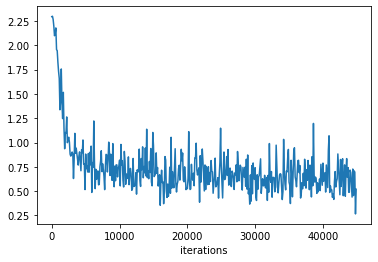

In [0]:
print("training loss curve")
plt.plot([100*i for i in range(len(loss_log))], loss_log)
plt.xlabel("iterations")